# Modeling

* Evaluation metric will be accuracy


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pylab as plt
from joblib import dump, load
import shap
import warnings
from sklearn.metrics import r2_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from os.path import dirname, abspath
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)


In [2]:
d = dirname(dirname(abspath("Modeling.ipynb")))

df = pd.read_csv(d + '/../data/bank-additional/bank-additional-full.csv', sep = ";")

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Helper Functions

In [3]:
REGRESSION_TYPE = "regression"
CLASSIFICATION_TYPE = "classification"

PREDICTION_TYPE = CLASSIFICATION_TYPE

# this is a classification problem

In [4]:
def preprocess_data(df, numeric_features, categorical_features, ordinal_features, ordinal_categories, label, random_state=7, stratify=False):
    """Helper function to preprocess data. Builds pipeline step for feature scaling, one hot encoding, and split of train/test and validation sets.
        ----------
        df : pandas dataframe object
        numeric_features : list of numerical feature names
        categorical_features : list of categorical feature names
        numeric_features : list of numerical feature names
        ordinal_features : list of ordinal feature names
        ordinal_categories : list of ordinal feature categories (list of lists)
        label : name of the label column
        random_state : int, optional
            random seed to use
        stratify : boolean, optional
            whether to split the data using stratification
        Returns
        -------
        X_cv : X for cross validation 
        X_validation : X for validation
        y_cv : y for cross validation
        y_validation : y for validation
        preprocessor : pipeline step for preprocessing
    """

    # Combine all input features
    X = df[numeric_features + categorical_features]

    # Encode the output label
    le = LabelEncoder()
    y = le.fit_transform(df[label])
    
    # Create the preprocessing pipelines for both numeric and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('ord', OrdinalEncoder(categories = ordinal_categories), ordinal_features)])
    
    # Create the train/test and validation sets
    if stratify:
        X_cv, X_validation, y_cv, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_state**1, stratify=y)
    else:
        X_cv, X_validation, y_cv, y_validation = train_test_split(X, y, test_size=0.2, random_state=random_state**1)

    # Return data and pipeline step
    return X_cv, X_validation, y_cv, y_validation, preprocessor


In [5]:
def cross_validate_model(model, param_grid, preprocessor, X_cv, y_cv, n_splits=5, n_repeats=1, random_state=7, preprocess=True, verbose=5):
    """Helper function to perform repeated k fold cross validation for a model. Uses a grid search to find optimal hyperparameters.
        ----------
        model : a sklearn model to fit
        param_grid : a dictionary of hyperparameter values
        preprocessor : pipeline step for preprocessing
        X_cv : X for cross validation 
        y_cv : y for cross validation
        n_splits : int, optional
            k to use for k fold cross validation
        n_repeats : int, optional
            number of times to repeat cross validation
        random_state : int, optional
            k to use for k fold cross validation
        preprocess : int, boolean
            perform preprocessing steps
        verbose : int, optional
            amount of printing
        Returns
        -------
        grid : all results from cross validation
    """
    
    # Get all hyperparameters
    keys = list(param_grid.keys())
    for key in keys:
        param_grid['model__' + key] = param_grid.pop(key)
    
    # Generate pipeline
    if preprocess:
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    else:
        pipe = Pipeline(steps=[('model', model)])
        
    # Perform grid search for hyperparameters using repeated k fold cross validation
    if PREDICTION_TYPE == CLASSIFICATION_TYPE:
        scoring = ['accuracy', 'neg_log_loss']
        main_metric = 'accuracy'
        refit = 'accuracy'
    elif PREDICTION_TYPE == REGRESSION_TYPE:
        scoring = 'neg_mean_squared_error'
        refit = 'neg_mean_squared_error'
    grid = GridSearchCV(pipe, param_grid, cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state**2), n_jobs=-1, return_train_score=True, 
                                scoring=scoring, refit=refit, verbose=verbose)

    # Fit to data
    grid.fit(X_cv, y_cv)
    
    # Return all results of model training
    return grid


In [6]:
def get_cross_validation_results(grid, X_validation, y_validation, y_cv):
    """Helper function to analyze cross validation results and print out metrics.
        ----------
        grid : all results from cross validation
        X_validation : X for validation
        y_validation : y for validation
        y_cv : y for model training
    """

    # Get index of best result
    if PREDICTION_TYPE == CLASSIFICATION_TYPE:
        best_param_idx = grid.cv_results_['rank_test_accuracy'].argmin()
        # Get metrics
        cv_log_loss = -grid.cv_results_['mean_test_neg_log_loss'][best_param_idx]
        cv_accuracy = grid.best_score_
    elif PREDICTION_TYPE == REGRESSION_TYPE:
        best_param_idx = grid.cv_results_['rank_test_score'].argmin()
        # Get metrics
        cv_MSE = -grid.cv_results_['mean_test_score'][best_param_idx]

    # Get best hyperparameter combination
    cv_params = grid.best_params_
    keys = list(cv_params.keys())
    for key in keys:
        cv_params[key.split("__")[1]] = cv_params.pop(key)
    validation_score = grid.score(X_validation, y_validation)
    
    # Print out all info
    model_name = type(grid.best_estimator_.steps[-1][1]).__name__
    if PREDICTION_TYPE == CLASSIFICATION_TYPE:
        print("{}\nCross Validation Results:\n\tAccuracy: {}\n\tLog Loss: {}\n\tBest Parameters: {}\nValidation Accuracy: {}".format(
            model_name, cv_accuracy, cv_log_loss, cv_params, validation_score))
    elif PREDICTION_TYPE == REGRESSION_TYPE:
        naive_MSE = mean_squared_error(y_validation, [y_cv.mean()]*len(y_validation))
        improvement_percentage = (naive_MSE - (-validation_score)) / naive_MSE * 100
        print("{}\nCross Validation Results:\n\tMSE: {}\n\tBest Parameters: {}\nValidation MSE: {}\nImprovement: {}%".format(
            model_name, cv_MSE, cv_params, -validation_score, improvement_percentage))
    

In [7]:
from sklearn.metrics import confusion_matrix

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i < 1 :
                ax.text(j, i+.2, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
            elif i > 0:
                ax.text(j, i-.2, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## CV

**Note:**
* the documentation states "duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model."


In [8]:
# less important cols from permutation test to drop: 
# day_of_week, housing, age, previous, marital, loan, poutcome, defalut, job, education

numeric_features = ['campaign', 'pdays', 'emp.var.rate',
                'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

categorical_features = ['contact', 'month']

ordinal_features = []

ordinal_categories = [[]]

label = ['y']


In [9]:

X_cv, X_validation, y_cv, y_validation, preprocessor =  preprocess_data(df, numeric_features,
                                                                        categorical_features, 
                                                                        ordinal_features,
                                                                        ordinal_categories, 
                                                                        label, stratify = True)


In [10]:

classes, counts = np.unique(y_validation,return_counts=True)
print('Naive Accuracy: {}'.format(np.max(counts/len(y_validation))))
    

Naive Accuracy: 0.8873512988589464
Naive Accuracy: 0.8873512988589464


## Modeling


* KNeighbors

In [13]:
model_kn = KNeighborsClassifier()
param_grid = {'n_neighbors': [25, 50, 75]}
grid_KNN = cross_validate_model(model_kn, param_grid, preprocessor, X_cv, y_cv, n_splits=3, n_repeats=1, verbose=0)
get_cross_validation_results(grid_KNN, X_validation, y_validation, y_cv)


KNeighborsClassifier
Cross Validation Results:
	Accuracy: 0.9105614567526555
	Log Loss: 0.2637130220351812
	Best Parameters: {'n_neighbors': 25}
Validation Accuracy: 0.9151493080844866
KNeighborsClassifier
Cross Validation Results:
	Accuracy: 0.9105614567526555
	Log Loss: 0.2637130220351812
	Best Parameters: {'n_neighbors': 25}
Validation Accuracy: 0.9151493080844866


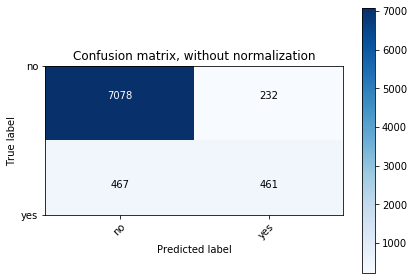

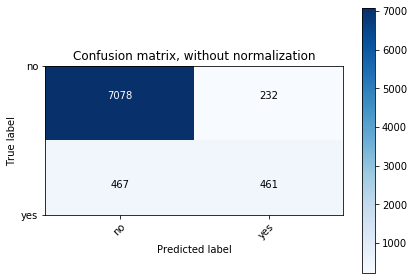

accuracy 0.9151493080844866
recall 0.49676724137931033
precision 0.6652236652236653
f1 0.5687847008019741
f_1/2: priority on precision 0.6229729729729729
f_1.5: priority on recall 0.538745055735347
accuracy 0.9151493080844866
recall 0.49676724137931033
precision 0.6652236652236653
f1 0.5687847008019741
f_1/2: priority on precision 0.6229729729729729
f_1.5: priority on recall 0.538745055735347


In [14]:
y_pred = grid_KNN.best_estimator_.predict(X_validation)

plot_confusion_matrix(y_validation,y_pred,classes=['no','yes'])
plt.show()

print('accuracy',accuracy_score(y_validation,y_pred))
print('recall',recall_score(y_validation,y_pred))
print('precision',precision_score(y_validation,y_pred))
print('f1',fbeta_score(y_validation,y_pred,1))
print('f_1/2: priority on precision',fbeta_score(y_validation,y_pred,0.5))
print('f_1.5: priority on recall',fbeta_score(y_validation,y_pred,1.5))


* SVC

In [15]:
model_svc = SVC(random_state=123, probability=True)
param_grid = {'C': [25, 50, 75], 'gamma': [1e-3, 1e-2, 1e-1]} # try different types of kernels
grid_SVC = cross_validate_model(model_svc, param_grid, preprocessor, X_cv, y_cv, n_splits=3, n_repeats=1, verbose=10)
get_cross_validation_results(grid_SVC, X_validation, y_validation, y_cv)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  2.6min remaining: 32.0min
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:  2.6min remaining: 32.0min
[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  2.7min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:  2.7min remaining: 11.7min
[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  2.8min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  2.8min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  2.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  2.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  3.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  3.3min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  17 out 

SVC
Cross Validation Results:
	Accuracy: 0.9118361153262519
	Log Loss: 0.24870718241042036
	Best Parameters: {'C': 25, 'gamma': 0.1}
Validation Accuracy: 0.9136926438455936
SVC
Cross Validation Results:
	Accuracy: 0.9118361153262519
	Log Loss: 0.24870718241042036
	Best Parameters: {'C': 25, 'gamma': 0.1}
Validation Accuracy: 0.9136926438455936


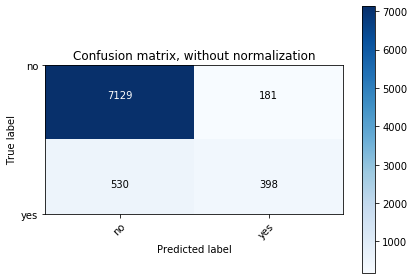

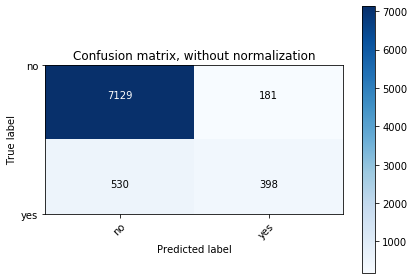

accuracy 0.9136926438455936
recall 0.42887931034482757
precision 0.687392055267703
f1 0.5282017252820173
f_1/2: priority on precision 0.6134401972872996
f_1.5: priority on recall 0.48500187476565426
accuracy 0.9136926438455936
recall 0.42887931034482757
precision 0.687392055267703
f1 0.5282017252820173
f_1/2: priority on precision 0.6134401972872996
f_1.5: priority on recall 0.48500187476565426


In [16]:
y_pred = grid_SVC.best_estimator_.predict(X_validation)

plot_confusion_matrix(y_validation,y_pred,classes=['no','yes'])
plt.show()

print('accuracy',accuracy_score(y_validation,y_pred))
print('recall',recall_score(y_validation,y_pred))
print('precision',precision_score(y_validation,y_pred))
print('f1',fbeta_score(y_validation,y_pred,1))
print('f_1/2: priority on precision',fbeta_score(y_validation,y_pred,0.5))
print('f_1.5: priority on recall',fbeta_score(y_validation,y_pred,1.5))


* XGBoost

In [17]:
model_xgb = GradientBoostingClassifier(random_state=123)
param_grid = {'max_depth': [4, 5, 6], 'n_estimators': [50, 75, 100], 'learning_rate': [.01, .05, .1]}
grid_GBC = cross_validate_model(model_xgb, param_grid, preprocessor, X_cv, y_cv, n_splits=3, n_repeats=1, verbose=10)
get_cross_validation_results(grid_GBC, X_validation, y_validation, y_cv)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:  1.0min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:  1.0min remaining:   22.9s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:  1.2min remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:  1.2min remaining:   13.5s
[Parallel(n_jobs=-1)]: Don

GradientBoostingClassifier
Cross Validation Results:
	Accuracy: 0.9167830045523521
	Log Loss: 0.18275830063364742
	Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 75}
Validation Accuracy: 0.91854819130857
GradientBoostingClassifier
Cross Validation Results:
	Accuracy: 0.9167830045523521
	Log Loss: 0.18275830063364742
	Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 75}
Validation Accuracy: 0.91854819130857


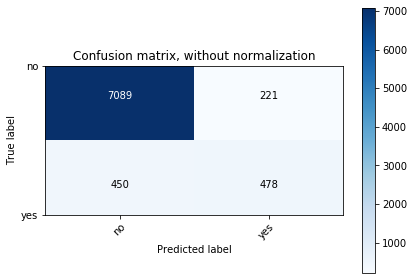

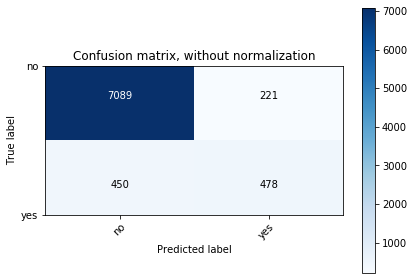

accuracy 0.91854819130857
recall 0.5150862068965517
precision 0.6838340486409156
f1 0.5875845113706207
f_1/2: priority on precision 0.641783029001074
f_1.5: priority on recall 0.5574094007893793
accuracy 0.91854819130857
recall 0.5150862068965517
precision 0.6838340486409156
f1 0.5875845113706207
f_1/2: priority on precision 0.641783029001074
f_1.5: priority on recall 0.5574094007893793


In [18]:
y_pred = grid_GBC.best_estimator_.predict(X_validation)

plot_confusion_matrix(y_validation,y_pred,classes=['no','yes'])
plt.show()

print('accuracy',accuracy_score(y_validation,y_pred))
print('recall',recall_score(y_validation,y_pred))
print('precision',precision_score(y_validation,y_pred))
print('f1',fbeta_score(y_validation,y_pred,1))
print('f_1/2: priority on precision',fbeta_score(y_validation,y_pred,0.5))
print('f_1.5: priority on recall',fbeta_score(y_validation,y_pred,1.5))


* MLP

In [19]:
model_mlp = MLPClassifier(random_state=123)
param_grid = {'hidden_layer_sizes': [(100,), (100,100,), (100,100,100)], 'learning_rate_init': [.01, .001, .0001]}
grid_nn = cross_validate_model(model_mlp, param_grid, preprocessor, X_cv, y_cv, n_splits=3, n_repeats=1, verbose=10)
get_cross_validation_results(grid_nn, X_validation, y_validation, y_cv)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:   45.6s remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:   45.6s remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:   51.5s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   5 out of  27 | elapsed:   51.5s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:   58.3s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:   58.3s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  2.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  2.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  17 out of  27 | elapsed:  2.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  17 

MLPClassifier
Cross Validation Results:
	Accuracy: 0.9145068285280729
	Log Loss: 0.18123511487989122
	Best Parameters: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001}
Validation Accuracy: 0.9187909686817188
MLPClassifier
Cross Validation Results:
	Accuracy: 0.9145068285280729
	Log Loss: 0.18123511487989122
	Best Parameters: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.0001}
Validation Accuracy: 0.9187909686817188


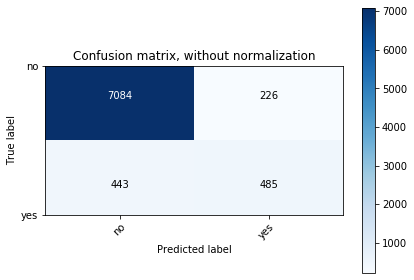

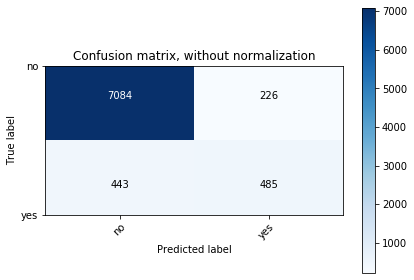

accuracy 0.9187909686817188
recall 0.5226293103448276
precision 0.6821378340365682
f1 0.5918242830994509
f_1/2: priority on precision 0.6428950159066809
f_1.5: priority on recall 0.5631475526973918
accuracy 0.9187909686817188
recall 0.5226293103448276
precision 0.6821378340365682
f1 0.5918242830994509
f_1/2: priority on precision 0.6428950159066809
f_1.5: priority on recall 0.5631475526973918


In [20]:
y_pred = grid_nn.best_estimator_.predict(X_validation)

plot_confusion_matrix(y_validation,y_pred,classes=['no','yes'])
plt.show()

print('accuracy',accuracy_score(y_validation,y_pred))
print('recall',recall_score(y_validation,y_pred))
print('precision',precision_score(y_validation,y_pred))
print('f1',fbeta_score(y_validation,y_pred,1))
print('f_1/2: priority on precision',fbeta_score(y_validation,y_pred,0.5))
print('f_1.5: priority on recall',fbeta_score(y_validation,y_pred,1.5))

## Model Selection

* *Note: baseline accuracy = 0.887*
* XGBoost has marginally outperformed the other models in terms of accuracy, precision, and recall


## Global Feature Importance

In [21]:
nr_runs = 10
ftr_names = np.array(numeric_features + categorical_features)
scores = np.zeros([len(ftr_names),nr_runs])

grid = grid_GBC

test_score = grid.score(X_validation,y_validation)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_validation == 0)/len(y_validation))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_validation.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_validation[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_validation))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.91854819130857
test baseline =  0.8873512988589464
shuffling duration
test score =  0.91854819130857
test baseline =  0.8873512988589464
shuffling duration
   shuffled test score: 0.867 +/- 0.002
shuffling campaign
   shuffled test score: 0.867 +/- 0.002
shuffling campaign
   shuffled test score: 0.918 +/- 0.0
shuffling pdays
   shuffled test score: 0.918 +/- 0.0
shuffling pdays
   shuffled test score: 0.912 +/- 0.001
shuffling emp.var.rate
   shuffled test score: 0.912 +/- 0.001
shuffling emp.var.rate
   shuffled test score: 0.917 +/- 0.001
shuffling cons.price.idx
   shuffled test score: 0.917 +/- 0.001
shuffling cons.price.idx
   shuffled test score: 0.917 +/- 0.0
shuffling cons.conf.idx
   shuffled test score: 0.917 +/- 0.0
shuffling cons.conf.idx
   shuffled test score: 0.916 +/- 0.0
shuffling euribor3m
   shuffled test score: 0.916 +/- 0.0
shuffling euribor3m
   shuffled test score: 0.907 +/- 0.001
shuffling nr.employed
   shuffled test score: 0.907 +/- 0.001
shuf

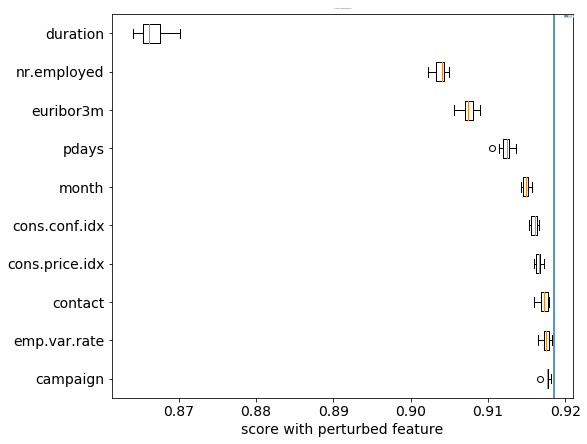

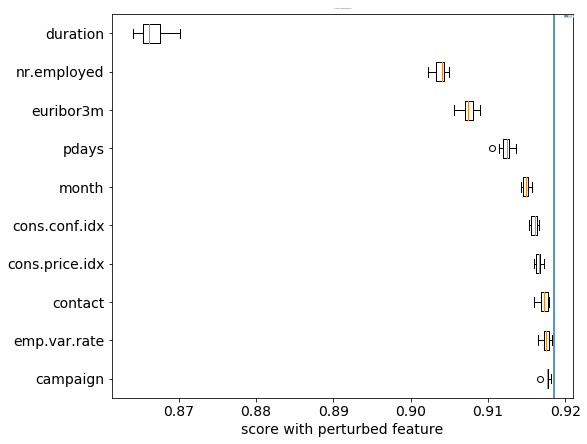

In [25]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
SMALL_SIZE = 0.5
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.legend()
plt.tight_layout()
plt.show()


**Notes:**
* The permutation test above shows that the most imporant column seems to be "duration"
* This is consistant with the hunch from EDA (remembering the histograms from EDA.ipynb)
